In [1]:
# !pip install lifelines

In [2]:
'''BASIC'''
import numpy as np
import pandas as pd
import random as rand
import datetime
import math
import os
import itertools as itr
import warnings
warnings.simplefilter('ignore')
'''PLOT'''
import seaborn as sns
sns.set(style="ticks", color_codes=True)
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

plt.style.use('ggplot')
font = {'size':16}
'''STATS'''
import scipy.stats as scs
import statsmodels.api as sm

from sklearn.model_selection import train_test_split

from lifelines import CoxPHFitter 
from lifelines import KaplanMeierFitter

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

'''RETURN'''
os.system("say 'loading complete' &");

In [3]:
def churnpipe(file, disp=False, impute=True):
    # read
    X = pd.read_csv('data/'+file)
    # create labels based on usage in the past 30 days
    X['churn_yes'] = (pd.to_datetime(X['last_trip_date']) < pd.to_datetime('2014-06-01')) * 1
    
    X['tenure'] = (pd.to_datetime(X['last_trip_date']) - pd.to_datetime(X['signup_date'])).dt.days
    
    X['luxury_car_user'] = X['luxury_car_user'] * 1
    
    # dummies for null ratings or impute
    if impute == True:
        X['avg_rating_by_driver'].fillna(0, inplace=True)
        X['avg_rating_of_driver'].fillna(0, inplace=True)
    else:
        X['rating_by_driver_missing'] = X['avg_rating_by_driver'].isnull()
        X['rating_of_driver_missing'] = X['avg_rating_of_driver'].isnull()
        X.drop(['avg_rating_by_driver', 'avg_rating_of_driver'], axis=1, inplace=True)
#     # dummies for categorical variables
    X = X.join(pd.get_dummies(X['phone'], prefix='phone', prefix_sep='_',drop_first=True, dummy_na=True))
    X = X.join(pd.get_dummies(X['city'], prefix='city', prefix_sep='_',drop_first=True))
    # remove the original variables
    X.drop(['city','phone','last_trip_date', 'signup_date'], axis=1, inplace=True)
    # printout
    if disp == True:
        print(X.info())
        print(X['churn_yes'].value_counts(normalize=True))
    # output
    
    return X



In [4]:
df = churnpipe('churn_train.csv', impute=False)

In [5]:
df.head()

,avg_dist,avg_surge,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,churn_yes,tenure,rating_by_driver_missing,rating_of_driver_missing,phone_iPhone,phone_nan,city_King's Landing,city_Winterfell
0,6.94,1.00,0.0,0,0,100.0,1,111,False,False,0,0,0,0
1,8.06,1.00,0.0,2,1,0.0,1,1,False,False,0,0,0,0
2,21.50,1.00,0.0,1,1,100.0,1,139,False,True,1,0,0,1
3,9.46,2.75,100.0,1,0,100.0,1,1,False,True,0,0,0,1
4,13.77,1.00,0.0,0,0,100.0,1,102,False,True,1,0,0,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
avg_dist                    40000 non-null float64
avg_surge                   40000 non-null float64
surge_pct                   40000 non-null float64
trips_in_first_30_days      40000 non-null int64
luxury_car_user             40000 non-null int64
weekday_pct                 40000 non-null float64
churn_yes                   40000 non-null int64
tenure                      40000 non-null int64
rating_by_driver_missing    40000 non-null bool
rating_of_driver_missing    40000 non-null bool
phone_iPhone                40000 non-null uint8
phone_nan                   40000 non-null uint8
city_King's Landing         40000 non-null uint8
city_Winterfell             40000 non-null uint8
dtypes: bool(2), float64(4), int64(4), uint8(4)
memory usage: 2.7 MB


In [7]:
df.corr()

,avg_dist,avg_surge,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,churn_yes,tenure,rating_by_driver_missing,rating_of_driver_missing,phone_iPhone,phone_nan,city_King's Landing,city_Winterfell
avg_dist,1.000000,-0.079488,-0.102349,-0.135228,0.025824,0.097445,0.093371,-0.109960,0.006097,0.128977,-0.023702,0.021027,0.013527,0.031272
avg_surge,-0.079488,1.000000,0.793842,-0.001829,-0.075544,-0.113054,0.003146,-0.017094,0.030417,0.008650,0.011530,-0.009959,-0.007347,-0.028452
surge_pct,-0.102349,0.793842,1.000000,0.004746,-0.103531,-0.147969,-0.011551,0.003074,0.026194,-0.003616,0.013835,-0.013156,0.028099,-0.065744
trips_in_first_30_days,-0.135228,-0.001829,0.004746,1.000000,0.114741,0.049731,-0.210677,0.164375,-0.028658,-0.195383,0.056907,0.002541,0.022333,0.037260
luxury_car_user,0.025824,-0.075544,-0.103531,0.114741,1.000000,0.033478,-0.206902,0.168140,-0.026764,-0.035403,0.064507,0.044101,0.039428,-0.053481
weekday_pct,0.097445,-0.113054,-0.147969,0.049731,0.033478,1.000000,-0.008383,0.020569,-0.013390,-0.023297,0.005988,0.014019,0.031314,-0.012731
churn_yes,0.093371,0.003146,-0.011551,-0.210677,-0.206902,-0.008383,1.000000,-0.777865,0.023472,0.156750,-0.227084,0.012698,-0.263103,0.046711
tenure,-0.109960,-0.017094,0.003074,0.164375,0.168140,0.020569,-0.777865,1.000000,-0.038631,-0.182964,0.189017,-0.030758,0.195179,-0.044947
rating_by_driver_missing,0.006097,0.030417,0.026194,-0.028658,-0.026764,-0.013390,0.023472,-0.038631,1.000000,0.032554,0.000091,0.003134,0.000016,0.006778
rating_of_driver_missing,0.128977,0.008650,-0.003616,-0.195383,-0.035403,-0.023297,0.156750,-0.182964,0.032554,1.000000,-0.057651,0.024292,-0.048402,0.019423


In [8]:
# multicolinearity between 'avg_surge' and 'surge_pct'

df2 = df.drop('avg_surge', axis = 1)

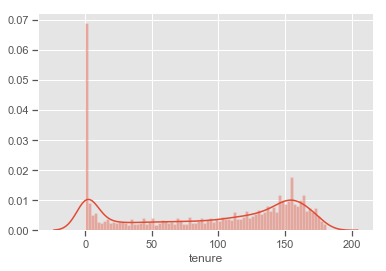

In [9]:
sns.distplot(df2['tenure'],bins=80);

In [10]:
df2.tenure.max()

pct_25 = np.quantile(df2['tenure'], 0.25)
pct_50 = np.quantile(df2['tenure'], 0.5)
pct_75 = np.quantile(df2['tenure'], 0.75)
pct_25, pct_50, pct_75

181

(26.0, 110.0, 150.0)

In [11]:
kmf = KaplanMeierFitter()
T = df2["tenure"]
E = df2["churn_yes"]

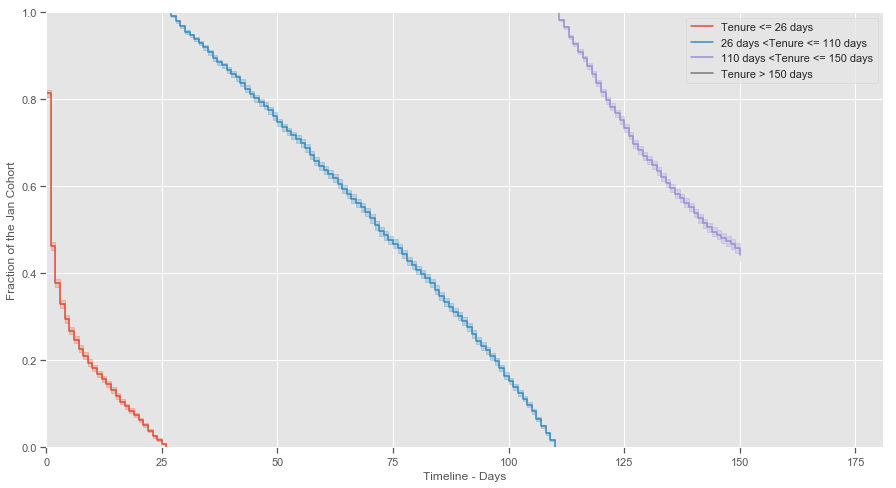

In [12]:
f = plt.figure(figsize=(15,8))

ax = f.add_subplot(111)

mask1 = (df2.tenure <= pct_25)
mask2 = (df2.tenure > pct_25) & (df2.tenure <= pct_50)
mask3 = (df2.tenure > pct_50) & (df2.tenure <= pct_75)
mask4 = (df2.tenure > pct_75 )

kmf.fit(T[mask1], event_observed=E[mask1], label="Tenure <= 26 days")
kmf.plot(ax=ax)
kmf.fit(T[mask2], event_observed=E[mask2], label="26 days <Tenure <= 110 days")
kmf.plot(ax=ax)
kmf.fit(T[mask3], event_observed=E[mask3], label="110 days <Tenure <= 150 days")
kmf.plot(ax=ax)
kmf.fit(T[mask4], event_observed=E[mask4], label="Tenure > 150 days")
kmf.plot(ax=ax)

plt.xlabel('Timeline - Days')
plt.ylabel('Fraction of the Jan Cohort')
plt.ylim(0, 1);

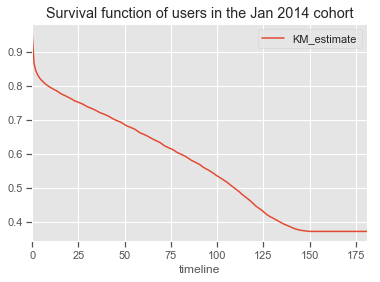

In [13]:
kmf.fit(T, event_observed=E)
kmf.survival_function_.plot()
plt.title('Survival function of users in the Jan 2014 cohort');

In [14]:
kmf.median_

# The median time being an active user, which defines the point in time where
# on average 1/2 of the cohort have churned. 110/30 - roughly 3.7 months.

110.0

In [15]:
cph_train, cph_test = train_test_split(df2, test_size=0.2, random_state =1) 
cph = CoxPHFitter(penalizer=0.1)
cph.fit(cph_train, duration_col='tenure', event_col='churn_yes',show_progress=True)

Iteration 7: norm_delta = 0.00000, step_size = 1.0000, ll = -195323.87368, newton_decrement = 0.00000, seconds_since_start = 0.5Convergence completed after 7 iterations.


<lifelines.CoxPHFitter: fitted with 32000 observations, 12061 censored>

#### Having a history of booking a luxury car in the first 30 days decreases the risk of churning. Being in the city of King's Landing decreases the risk of churning. Having missing ratings of drivers increases the risk of churning.

In [16]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 32000 observations, 12061 censored>
      duration col = 'tenure'
         event col = 'churn_yes'
         penalizer = 0.1
number of subjects = 32000
  number of events = 19939
partial log-likelihood = -195323.87
  time fit was run = 2019-08-08 23:32:05 UTC

---
                          coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
avg_dist                  0.01      1.01      0.00            0.01            0.01                1.01                1.01
surge_pct                -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
trips_in_first_30_days   -0.06      0.94      0.00           -0.07           -0.05                0.94                0.95
luxury_car_user          -0.43      0.65      0.02           -0.46           -0.40                0.63                0.67
weekday_pct               0.00      1.00      0.00           -0.00            0.00   

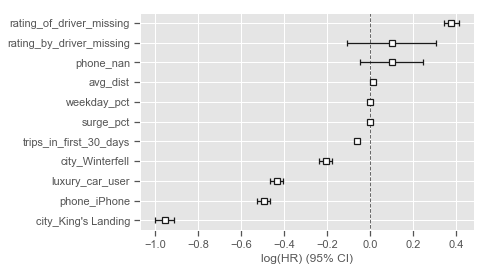

In [17]:
cph.plot()

In [18]:
censored_subjects = df.loc[df['churn_yes'] == 0]

In [19]:
unconditioned_sf = cph.predict_survival_function(censored_subjects)
unconditioned_sf.T.head()

T,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,172.0,173.0,174.0,175.0,176.0,177.0,178.0,179.0,180.0,181.0
12,0.968081,0.904803,0.888628,0.879425,0.872393,0.867269,0.863336,0.859095,0.855836,0.852967,...,0.447748,0.447748,0.447748,0.447748,0.447748,0.447748,0.447748,0.447748,0.447748,0.447748
14,0.936883,0.817870,0.788751,0.772419,0.760056,0.751111,0.744281,0.736952,0.731343,0.726424,...,0.198913,0.198913,0.198913,0.198913,0.198913,0.198913,0.198913,0.198913,0.198913,0.198913
25,0.972785,0.918432,0.904449,0.896476,0.890375,0.885925,0.882507,0.878819,0.875982,0.873483,...,0.504880,0.504880,0.504880,0.504880,0.504880,0.504880,0.504880,0.504880,0.504880,0.504880
30,0.980616,0.941421,0.931230,0.925398,0.920926,0.917658,0.915145,0.912430,0.910339,0.908497,...,0.615784,0.615784,0.615784,0.615784,0.615784,0.615784,0.615784,0.615784,0.615784,0.615784
31,0.970069,0.910545,0.895289,0.886600,0.879957,0.875115,0.871397,0.867387,0.864303,0.861589,...,0.471089,0.471089,0.471089,0.471089,0.471089,0.471089,0.471089,0.471089,0.471089,0.471089


In [20]:
conditioned_sf = unconditioned_sf.apply(lambda c: (c / c.loc[df.loc[c.name, 'tenure']]).clip_upper(1))

In [21]:
conditioned_sf.T.head()

T,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,172.0,173.0,174.0,175.0,176.0,177.0,178.0,179.0,180.0,181.0
12,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
14,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.947885,0.947885,0.947885,0.947885,0.947885,0.947885,0.947885,0.947885,0.947885,0.947885
30,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
31,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.971131,0.971131,0.971131,0.971131,0.971131,0.971131,0.971131,0.971131,0.971131,0.971131


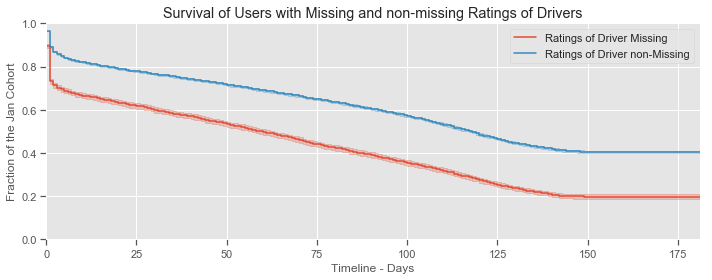

In [22]:
f = plt.figure(figsize=(10,4))

ax = f.add_subplot(111)

rating_missing = (df2["rating_of_driver_missing"] == True)

kmf.fit(T[rating_missing], event_observed=E[rating_missing], label="Ratings of Driver Missing")
kmf.plot(ax=ax)
kmf.fit(T[~rating_missing], event_observed=E[~rating_missing], label="Ratings of Driver non-Missing")
kmf.plot(ax=ax)

plt.xlabel('Timeline - Days')
plt.ylabel('Fraction of the Jan Cohort')
plt.ylim(0, 1);
plt.title("Survival of Users with Missing and non-missing Ratings of Drivers");
plt.tight_layout();

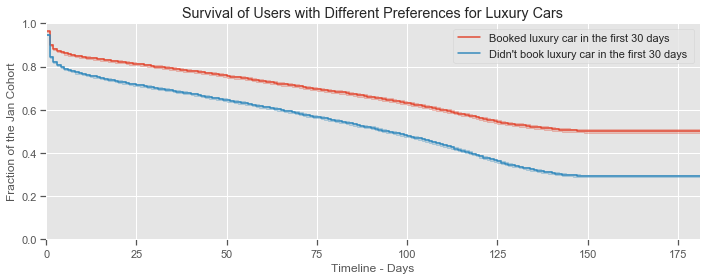

In [23]:
f = plt.figure(figsize=(10,4))

ax = f.add_subplot(111)
lux_car = (df2["luxury_car_user"] == True)

kmf.fit(T[lux_car], event_observed=E[lux_car], label="Booked luxury car in the first 30 days")
kmf.plot(ax=ax)
kmf.fit(T[~lux_car], event_observed=E[~lux_car], label="Didn't book luxury car in the first 30 days ")
kmf.plot(ax=ax)

plt.xlabel('Timeline - Days')
plt.ylabel('Fraction of the Jan Cohort')
plt.ylim(0, 1);
plt.title("Survival of Users with Different Preferences for Luxury Cars");
plt.tight_layout();

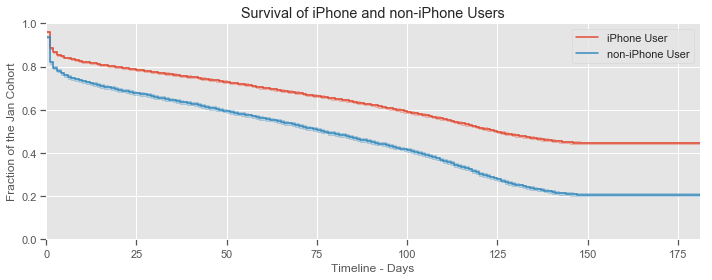

In [24]:
f = plt.figure(figsize=(10,4))

ax = f.add_subplot(111)

iphone_user = (df2["phone_iPhone"] == True)

kmf.fit(T[iphone_user], event_observed=E[iphone_user], label="iPhone User")
kmf.plot(ax=ax)
kmf.fit(T[~iphone_user], event_observed=E[~iphone_user], label="non-iPhone User")
kmf.plot(ax=ax)

plt.xlabel('Timeline - Days')
plt.ylabel('Fraction of the Jan Cohort')
plt.ylim(0, 1);
plt.title("Survival of iPhone and non-iPhone Users");
plt.tight_layout();

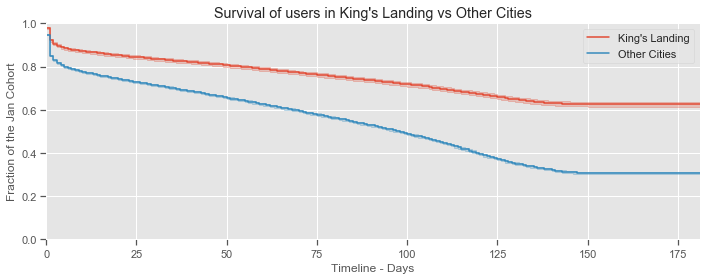

In [25]:
f = plt.figure(figsize=(10,4))

ax = f.add_subplot(111)

king_city = (df2["city_King's Landing"] == True)

kmf.fit(T[king_city], event_observed=E[king_city], label="King's Landing")
kmf.plot(ax=ax)
kmf.fit(T[~king_city], event_observed=E[~king_city], label="Other Cities")
kmf.plot(ax=ax)

plt.xlabel('Timeline - Days')
plt.ylabel('Fraction of the Jan Cohort')
plt.ylim(0, 1);
plt.title("Survival of users in King's Landing vs Other Cities");
plt.tight_layout();